In [6]:
#구글드라이브와 colab 파일 연결

from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
import matplotlib.pyplot as pylab
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from skimage.io import imread
from sklearn.utils import shuffle
from skimage import img_as_float
import matplotlib.image as mpimg

import matplotlib.pylab as pylab
from skimage import img_as_float

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline #얼굴 이미지 처리를 위해 필요한 모듈들 


def LoadFaceimg(): #얼굴 이미지를 불러오는 함수.
#0001_0001~0350_0005를 faces[0]~faces[1749] 로 불러옴.
#따라서 faces[index] 에서 사람 번호인 personID = (index // 5 + 1),
#사진 번호를 photoID라 하면 photoID = (index % 5 + 1) 와 같다.

  #1~9번 사람은 그 사람의 ID인 사진 파일 이름이 0001~0009,
  #10~99번은 0011~0099, 100~350번은 0100~0350 으로 되어있어
  #문자열을 맞추기 위해 ID가 한자릿수, 십자릿수, 백자릿수를 최대로 하는 것에 따라
  #for문을 따로 이용했다.

  faces = [] #face 배열 선언하여 얼굴 이미지들을 순서대로 삽입

  for i in range(1,10): #일의 자릿수 ID
    for j in range(1,6): 
      img = img_as_float(imread('/gdrive/My Drive/ColabNote/ARFaces/mpeg_000'+str(i)+'_000'+str(j)+'.BMP'))
      faces.append(img)

  for i in range(10,100): #십의 자릿수 ID
    for j in range(1,6): 
      img = img_as_float(imread('/gdrive/My Drive/ColabNote/ARFaces/mpeg_00'+str(i)+'_000'+str(j)+'.BMP'))
      faces.append(img)

  for i in range(100, 351): #백의 자릿수 ID
    for j in range(1,6): 
      img = img_as_float(imread('/gdrive/My Drive/ColabNote/ARFaces/mpeg_0'+str(i)+'_000'+str(j)+'.BMP'))
      faces.append(img)     

  faces = np.array(faces) #face에 모두 넣었으므로, 적절한 연산을 위해 numpy 배열로 바꾼다.
  
  return faces

<Figure size 432x288 with 0 Axes>

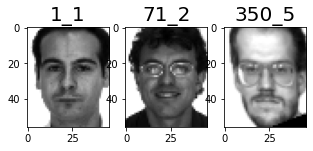

In [8]:
faces = LoadFaceimg() #이미지 불러오기.
pylab.gray()
#이미지가 잘 저장되었는지 확인
pylab.figure(figsize=(5,5))
pylab.subplot(1,3,1), pylab.axis('on')
pylab.title('1_1', size=20)
pylab.imshow(faces[0])

pylab.subplot(1,3,2), pylab.axis('on')
pylab.title('71_2', size=20)
pylab.imshow(faces[5*(71-1) + (2-1)])

pylab.subplot(1,3,3), pylab.axis('on')
pylab.title('350_5', size=20)
pylab.imshow(faces[1749])


pylab.show()

(1750, 2576)


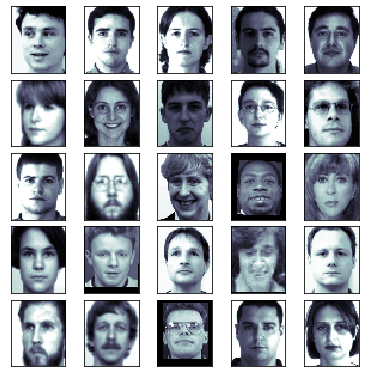

In [10]:
#데이터셋의 얼굴 몇 개 보기
faces = faces.reshape((1750, 56*46)) # 1750개의 이미지를 각각 하나의 배열로 생각한다.
print(faces.shape) #(1750, 56*46) -> (56*46) 화소의 400개의 얼굴 영상


fig = pylab.figure(figsize=(5,5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.1)

#25개의 랜덤 얼굴 표시
j=1
np.random.seed(4)
for i in np.random.choice(range(faces.shape[0]), 25):
  ax = fig.add_subplot(5,5,j,xticks=[],yticks=[])
  face = np.reshape(faces[i,:], (56,46))
  ax.imshow(face, cmap='bone', interpolation='nearest')
  j += 1

pylab.show()

In [11]:
#training set과 test set 나누기
faces_train = [] #학습데이터
faces_test = [] #테스트데이터

#한 사람당 얼굴 데이터가 5개씩 있었으므로,
for i in range(0,1750):
  #photoID = (index % 5 - 1) 이므로, i%5 == 0 이면, 각 사람의 1번 얼굴
  if( i%5 == 0 ): #n번째 사람의 1번 data는 test data로
    faces_test.append(faces[i])
  else: #2~5번 data는 training data로 사용
    faces_train.append(faces[i])


faces_train = np.array(faces_train)
faces_test = np.array(faces_test)
print(len(faces_train), len(faces_test), len(faces_train)+len(faces_test))

1400 350 1750


In [12]:
faces_train.shape

(1400, 2576)

(1400, 400)


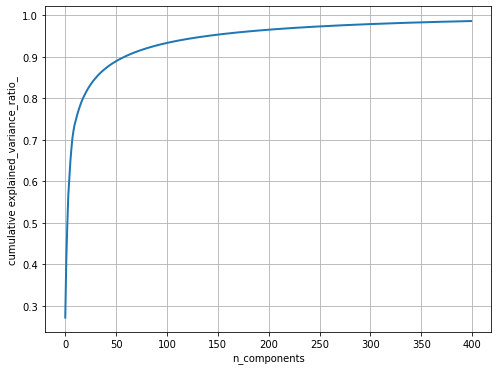

In [13]:
#주성분의 variation을 살펴보기

n_comp = 400  #파이썬에서 사용 가능한 최대 차원인 400차원으로 돌려보기.
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_comp))])
#faces_proj = pipeline.fit_transform(faces)  #전체 데이터에 대해 
faces_proj = pipeline.fit_transform(faces_train) #faces_train(학습데이터)에 대해 pca 정보 적용 400차원으로
print(faces_proj.shape)


#대략 50~60 사이에서 0.9 선과 만나는 것을 알 수 있었음
pylab.figure(figsize=(8,6))
variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_
pylab.plot(np.cumsum(variance_ratio), linewidth=2)
pylab.grid(),pylab.axis('tight'),pylab.xlabel('n_components')
pylab.ylabel('cumulative explained_variance_ratio_')
pylab.show()  

In [14]:
#누적값이 0.9가 되는 주성분 개수를 찾기 위해 사용
pca = PCA(0.9)
pca.fit(faces_train)
print(pca.n_components_) #51

51


(1400, 51)


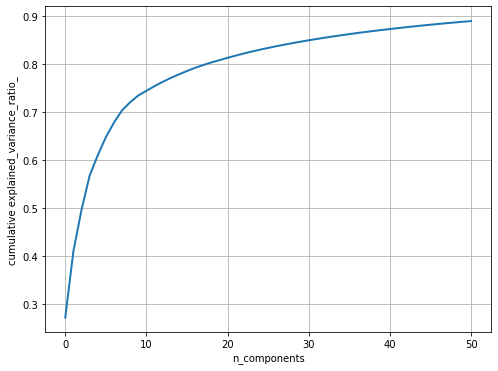

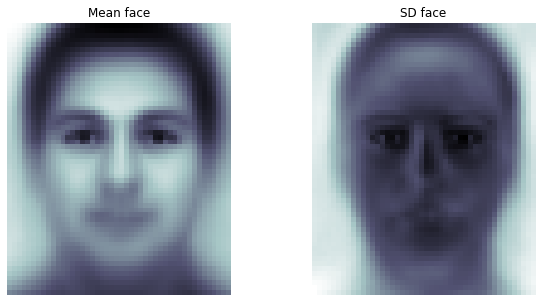

In [15]:
n_comp = 51
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_comp))])
faces_proj = pipeline.fit_transform(faces_train) #학습 데이터에 대해 51차원으로 pca 정보 적용 
print(faces_proj.shape)


#평균 얼굴과 얼굴의 차이값 계산.
mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, (56,46))
#평균 얼굴 : 각 얼굴의 화소/인덱스별로 평균 계산
sd_face = np.reshape(np.sqrt(pipeline.named_steps['scaling'].var_), (56,46)) 
#얼굴의 차이값(각 얼굴 화소 - 해당 화소 인덱스의 평균)
#주성분 찾은 것을 단위 벡터로 var_


pylab.figure(figsize=(8,6))
variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_ #고유값
pylab.plot(np.cumsum(variance_ratio), linewidth=2)
pylab.grid(),pylab.axis('tight'),pylab.xlabel('n_components')
pylab.ylabel('cumulative explained_variance_ratio_')
pylab.show()


#mean_face와 sd_face 출력해보기
#새벽에 과제하는데 얼굴이 무서워서 잠시 주석 처리
pylab.figure(figsize=(10,5))
pylab.subplot(121), pylab.imshow(mean_face, cmap='bone')
pylab.axis('off'), pylab.title('Mean face')
pylab.subplot(122), pylab.imshow(sd_face, cmap='bone')
pylab.axis('off'), pylab.title('SD face')
pylab.show()


(51, 2576)
Top 10 Eigenvalue: 698.982  356.446  222.385  183.839  109.304  97.941  78.325  66.11  43.521  36.273  

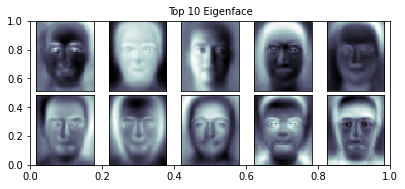

In [16]:
#고유 얼굴과 고유값 상위 10개 보여주기

#51개 주성분에 대한 고유 얼굴
print(pca.components_.shape)

fig = pylab.figure(figsize=(5,2))
fig.subplots_adjust(left = 0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

print('Top 10 Eigenvalue:', end= ' ') #첫 10개 고유값 표시
pylab.title('Top 10 Eigenface', size = 10) #첫 10개 고유얼굴 표시

for i in range(10): 
  print(round(pipeline.named_steps['pca'].explained_variance_[i], 3), end = '  ') #고윳값 explained_variance_를 이용하며,
  # 소숫점 4째자리에서 반올림했다.

  face = np.reshape(pipeline.named_steps['pca'].components_[i,:],(56,46))
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  ax.imshow(face, cmap='bone', interpolation='nearest')

pylab.show()


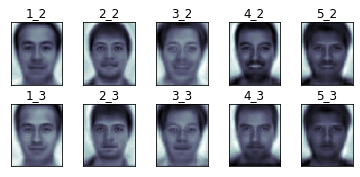

In [17]:
#얼굴 재구성
faces_inv_proj = pipeline.named_steps['pca'].inverse_transform(faces_proj) 
faces_inv_proj = np.reshape(faces_inv_proj, (1400,56,46)) #56*46 차원의 이미지 1400개 형태 변환 (학습데이터에 대해)

fig = pylab.figure(figsize = (5,2))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.3, wspace=0.05)


k = 1
#학습데이터 10개에 대한 재구성얼굴
#1~5번 사람의 2, 3번 얼굴에 해당하는 재구성얼굴 보여줌
for j in range(2):
  for i in range(5):
    reconst_face = mean_face + sd_face*faces_inv_proj[i*4 + j,:]   
    #faces_proj가 faces_train에 대해 이루어졌기 때문에 각 사람당 4개의 얼굴 데이터가 있고, 
    #j가 0이면 그 사람의 2번 얼굴이다. i*4 + j 는 i+1 번째 사람의 j+2번 데이터.


    #주성분을 토대로 이미지 재구성 - 원본 이미지에 가까운 이미지로 주성분 수가 적을수록 뿌옇게 보임
    #reconst_face = face_inv_proj[i,:] 주성분 분석을 이용한 얼굴의 특징벡터
    ax = fig.add_subplot(2,5, k, xticks=[], yticks=[])
    ax.imshow(reconst_face, cmap='bone', interpolation='nearest')
    pylab.title('{}_{}'.format(i+1,j+2))
    k+=1

pylab.show()

(-0.5, 45.5, 55.5, -0.5)

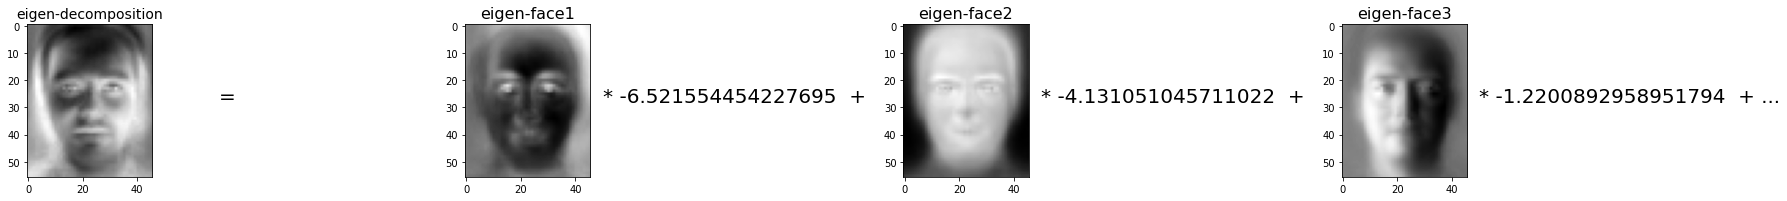

In [18]:
#2 : 고유분해
# 원본얼굴 = 고유얼굴1의 고유값 * 고유얼굴1 + 고유얼굴2의 고유값 * 고유얼굴2 + 고유얼굴3의 고유값 * 고유얼굴3 + ...
decomp_face = 0


eface = pipeline.named_steps['pca'].components_
eface = np.reshape(eface, (51,56,46)) #고유 얼굴

faces_proj = pca.transform(faces_train) #고유 값


fig = pylab.figure(figsize = (20,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=2.5)

#고유분해 : 여기서는 1번 사람의 2번 얼굴만 진행했다.
#faces_proj에는 faces_train이 기준이므로, 
#faces_proj[n] 은 n//4 + 1 번 사람의 n%4 + 2 번 얼굴에 대한 투영값.
for i in range(0,len(eface)):
  decomp_face += faces_proj[0][i]*eface[i]
  #얼굴의 고유분해 : i번째 고유값 * 고유얼굴 i 를 고유얼굴 전체에 대해 모두 더함.


#얼굴들을 선형결합 형태로 보여주기 위한 pylab 코드들
#51개의 고유얼굴과 고유값을 모두 보여주기엔 너무 많아서 3개만 출력했다.
pylab.subplot(1,4,1), pylab.title('eigen-decomposition', size = 14)
pylab.imshow(decomp_face)
pylab.text(70,28, '=', size = 20)

pylab.subplot(1,4,2), pylab.title('eigen-face1', size = 16)
pylab.imshow(eface[0])
pylab.text(50,28, '* {}  +'.format(faces_proj[0][0]), size = 20)

pylab.subplot(1,4,3), pylab.title('eigen-face2', size = 16)
pylab.imshow(eface[1])
pylab.text(50,28, '* {}  +'.format(faces_proj[0][1]), size = 20)

pylab.subplot(1,4,4), pylab.title('eigen-face3', size = 16)
pylab.imshow(eface[2])
pylab.text(50,28, '* {}  + ...'.format(faces_proj[0][2]), size = 20)
  

#원래 1번 사람의 2번 얼굴
#orig_face = np.reshape(faces[1], (56,46))
#pylab.subplot(2,4,5), pylab.title('orig_face', size = 16)
#pylab.imshow(orig_face)

pylab.gray()
pylab.axis('on')

In [0]:
#3. identification / verification 에서 공통으로 사용할 거리 계산

#각 데이터의 특징벡터 = 주성분 축에 각 데이터를 투영시킴
#                   = tr(주성분 components_)*(얼굴-평균얼굴)

#특징벡터=특징얼굴=차원축소된 얼굴=투영된 얼굴 

#identification
#(1) 각 얼굴에 대한 특징벡터를 계산
#(2) 특징벡터 간의 거리를 계산
#(3) 거리가 가장 작은 4개의 얼굴은 동일 ID로 취급하여
#(4) mr 계산


#test data의 특징벡터 계산
#faces_proj = pca.transform(faces_train)
faces_test_proj = pca.transform(faces_test) #test data는 fit 단계를 거치지 않고 투영시킴
'''
#identification2 : 위에 나온 특징벡터 = tr(주성분 components_)*(얼굴-평균얼굴) 이용

#행렬 계산을 위해 mean_face, sd_face reshape
faces_test_proj = []
reshape_mean = np.reshape(mean_face, (2576,)) 
reshape_sd = np.reshape(sd_face, (2576,))

for i in range(350): #test_data 350개와
  for j in range(51): #주성분 51개에 대해 특징벡터 연산 수행
    vector = np.dot(np.transpose(pca.components_[j]),(faces_test[i]-reshape_mean)) #이렇게 하면 identification1과 같은 결과
    #vector = np.dot(np.transpose(pca.components_[j]),((faces_test[i]-reshape_mean)/reshape_sd)) #이렇게 하면 다른 결과
    faces_test_proj.append(vector)

faces_test_proj = np.array(faces_test_proj)
faces_test_proj = np.reshape(faces_test_proj, (350,51))

#print(faces_proj.shape)
#print(faces_test_proj.shape)
'''

#특징벡터간의 거리 계산
distance = np.zeros((350,350*4))

for i in range(0,350): #test
  for j in range(0, 350*4): #train
    distance[i][j] = np.sqrt(np.sum((faces_test_proj[i]-faces_proj[j])**2)) #거리는 유클리드 거리를 이용한다.
    #distance[i][j] 에는, (i+1)번째 사람의 1번째 얼굴과 (j//4 + 1))번째 사람의 (j%4 + 2) 번째 얼굴 사이의 거리가 담겨있음.

distance = np.array(distance)


#제대로 담겼는지 확인
#print(np.sqrt(np.sum((faces_test_proj[0]-faces_proj[0])**2)))
#print(distance[0][0])

#print(distance)
#print(len(distance[0]))

In [0]:
#다음에 나올 min의 초기값과 verification의 dth를 결정하기 위해 
#length 값을 변경하며 값이 있는지 알아봄.

length = 100
for i in range(350):
  for j in range(350*4):
    if(distance[i][j] > length): #거리
      print(distance[i][j])
      break

#거리값은 0~40 사이에 분포하고 있었다.

In [20]:
#3-1. identification
#거리가 가장 작은 얼굴 4개는 동일 ID로 취급한다.

min_index = 0
min_index_array = np.zeros((350,4))
dist_compare = np.zeros(350)

for i in range(350): #350개의 test data에 대해 1400개의 training data와 비교
  dist_compare = distance[i].copy()
  for k in range(4): #거리가 가장 작은 얼굴 4개를 찾기 위해 4번 반복
    min = 500           #거리가 가장 작은 얼굴 4개를 찾기 위해 min 값을 distance 값에 존재하지 않는 500으로 설정
    for j in range(350*4): #1400개의 training data와 비교
      if(min > dist_compare[j]): 
        min = dist_compare[j]
        min_index = j

    min_index_array[i][k] = min_index // 4 # 가장 작은 거리값의 id (0~349) 를 저장
    #배열 index 특성상 1~350인 ID가 0~349가 되었다.
    dist_compare[min_index] = 500 
    #가장 작은 거리값을 4개 찾아야 하므로, 
    #현재 가장 작은 값을 가지는 곳이 또 나오면 안됨. 그 곳의 값을 500으로 변경.

#따라서 min_index_array[i][k]에는 i번 사람의 test data와 1400개의 training data 사이의
#거리가 가장 가까운 순으로 4개의 data가 min_index_array[i][0]~min_index_array[i][3]에 담겨있다.

np.set_printoptions(suppress=True)
#print(min_index_array)


#matching_rate 계산
mr = np.zeros(350)
mr1count = 0

#거리가 가장 작은 4개의 얼굴을 같은 ID로 인식 했을 때
for i in range(350):
  mr4count = 0
  for j in range(4):
    if(i == min_index_array[i][j]): #ID가 같으면 count를 증가시킴.
      mr4count += 1 
  mr[i] = 100 * mr4count / 4    #test data 각각에 대해 4개 중 몇개의 ID가 일치하는지 퍼센트로 나타냄.

mr4_result = 0
for i in range(350):
  mr4_result += mr[i] / 350    #위에서 350개에 test data에 대해 각각 구한 일치비율의 평균을 낸다.



#거리가 가장 작은 1개의 얼굴을 같은 ID로 인식 했을 때
for i in range(350):
  if(i == min_index_array[i][0]): #ID가 같으면 count를 증가시킴.
    mr1count += 1

mr1result = 100*mr1count / 350 #전체 test data에 대해 같은 사람의 ID로 식별된 것의 비율을 퍼센트로 나타냄

print(mr1result, mr4_result)

89.71428571428571 51.0714285714287


In [22]:
#identification 시각화
for i in range(350):
  for j in range(4):
    print(int(min_index_array[i][j]), end = ' ')
  print(mr[i])

0 6 0 327 50.0
1 18 14 14 25.0
2 2 5 5 50.0
3 11 36 40 25.0
17 17 155 155 0.0
5 5 2 8 50.0
6 6 20 68 50.0
7 7 22 22 50.0
8 8 5 82 50.0
9 9 11 36 50.0
10 14 66 19 25.0
30 11 67 11 50.0
12 20 20 12 50.0
13 13 1 14 50.0
14 14 36 23 50.0
15 15 74 40 50.0
16 16 13 18 50.0
17 55 8 55 25.0
18 18 65 65 50.0
19 19 67 67 50.0
20 20 12 332 50.0
21 21 23 12 50.0
22 71 22 46 50.0
23 40 23 36 50.0
24 12 24 22 50.0
25 25 45 45 50.0
26 27 26 44 50.0
27 27 38 8 50.0
28 28 52 28 75.0
29 66 53 92 25.0
30 73 11 73 25.0
31 31 33 46 50.0
32 32 46 44 50.0
201 201 190 190 0.0
58 34 52 51 25.0
35 6 24 329 25.0
36 36 11 23 50.0
37 74 37 46 50.0
38 38 27 15 50.0
39 39 20 40 50.0
40 40 23 36 50.0
41 34 82 65 25.0
42 42 42 15 75.0
43 43 145 68 50.0
44 34 44 40 50.0
45 45 25 95 50.0
46 33 38 58 25.0
47 47 128 128 50.0
48 40 48 46 50.0
49 49 55 55 50.0
50 50 50 50 100.0
51 51 69 14 50.0
52 58 33 84 25.0
53 53 65 65 50.0
54 54 14 40 50.0
55 55 49 17 50.0
56 56 66 14 50.0
57 57 44 4 50.0
58 58 18 44 50.0
59 59 18 52 5

In [0]:
#확인용
#print(mr4)
#print(len(mr4))

count = 0
for i in range(350):
  if(mr[i] == 0):
    count += 1

print(count)

16


In [23]:
#3-2. verification
#dth를 적당히 10개 정해야 하는데 위에서 살펴본 결과
#distance 배열에 저장된 거리 값은 0~40 사이에 분포했으므로,
#0~40을 4부터 40까지 4 간격으로 10개로 나누기로 했다.
def Verification(dth):

  frr = np.zeros(350)
  far = np.zeros(350)


  #dth 보다 거리가 작으면 매칭된 것으로 판단.
  for i in range(350):
    frr_count = 0
    far_count = 0
    for j in range(350*4):
      if(i == j//4):  #ID가 같은 경우엔 frr 계산
        if(distance[i][j] < dth):
          frr_count += 1
      else:
        if(distance[i][j] < dth): #ID가 다른 경우엔 far 계산
          far_count += 1

    frr[i] = 100 * (4-frr_count) / 4 # i번 사람에 대한 frr 값 (i 번 사람의 test 얼굴 1개, i번 사람의 training 얼굴 4개) 
    far[i] = 100 * far_count / (4*349) # i번 사람에 대한 far 값 (i번 사람을 제외한 training 얼굴 4*349개)


  frr_result = 0
  far_result = 0
  for i in range(350): 
    frr_result += frr[i]
    far_result += far[i]

  frr_result = frr_result / 350
  far_result = far_result / 350
  #위에서 구한 350개의 test_data에 대해 각각 계산했던 frr, far 값을 평균내서 
  #전체 frr,far값을 구한다.

  print(frr_result, far_result)
  return frr_result, far_result



dth = 4
dths = np.zeros(10)
frr = np.zeros(10)
far = np.zeros(10)

#dth를 4 간격으로 10번 검증 함수 돌림
for i in range(10):
  dths[i] = dth
  frr[i], far[i] = Verification(dth) 
  dth += 4
#이 때, dth값과 verification 함수의 반환 값인 10개의 frr, far값을 배열에 저장하여 그래프를 그리는데 사용한다.

81.85714285714286 0.003069995906672124
46.714285714285715 0.7322963569381901
18.714285714285715 7.996316004911997
2.642857142857143 31.27445763405649
0.35714285714285715 64.88334015554645
0.2857142857142857 90.2052803929595
0.21428571428571427 98.71060171919784
0.07142857142857142 99.90626279164967
0.0 99.99611133851822
0.0 100.0


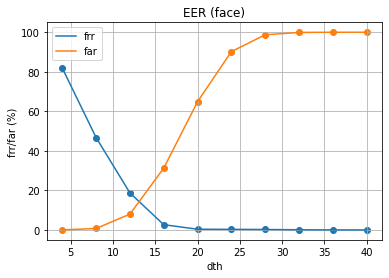

In [24]:
#3-3. EER 그래프 그리기 
import pandas as pd
import matplotlib.pyplot as plt


#그래프 선 그리기
plt.plot(dths, frr, label = 'frr')
plt.plot(dths, far, label = 'far')


#그래프 점 그리기
plt.scatter(dths, frr)
plt.scatter(dths, far)

#그래프 옵션
plt.grid()
plt.legend()
plt.xlabel('dth')
plt.ylabel('frr/far (%)')
plt.title('EER (face)')

plt.show()

In [26]:
#3-2. verification2
#거리가 가장 가깝게 나온 4개를 이용
def Verification2():

  frr = np.zeros(350)
  far = np.zeros(350)


  #거리가 가장 가까운 것을 이용하기 위해 identfication 단계에서 이용했던 min_index_array를 사용했다.
  for i in range(350):
    frr_count = 0
    far_count = 0
    for j in range(4):
      if(i == min_index_array[i][j]):  #ID가 같은 경우엔 frr 계산
          frr_count += 1
      else: #ID가 다른 경우엔 far 계산
          far_count += 1

    frr[i] = 100 * (4-frr_count) / 4 # i번 사람에 대해 같은 사람이 인식 frr 값 (i 번 사람의 test 얼굴 1개, i번 사람의 training 얼굴 4개) 
    far[i] = 100 * far_count / (4*349)     # i번 사람에 대해 다른 사람이라고 인식된 far 값


  frr_result = 0
  far_result = 0
  for i in range(350): 
    frr_result += frr[i]
    far_result += far[i]

  frr_result = frr_result / 350
  far_result = far_result / 350
  #위에서 구한 350개의 test_data에 대해 각각 계산했던 frr, far 값을 평균내서 
  #전체 frr,far값을 구한다.

  print(frr_result, far_result)
  return frr_result, far_result

Verification2() 

48.92857142857143 0.14019647973802674


(48.92857142857143, 0.14019647973802674)